# Get Data Files from Kaggle

---



In [0]:
#!rm -dr ~/.kaggle
!pip install -U -q kaggle

!mkdir -p ~/.kaggle
from google.colab import files


In [8]:
files.upload()


Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"oussamatn","key":"6a2e8a66785e7c90254580b027a26da8"}'}

In [3]:
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c ashrae-energy-prediction



sample_submission.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
building_metadata.csv: Skipping, found more recently modified local copy (use --force to force download)
weather_test.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
weather_train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
test.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)


In [10]:
!unzip weather_train.csv.zip
!unzip weather_test.csv.zip
!unzip test.csv.zip
!unzip train.csv.zip
!unzip sample_submission.csv.zip


Archive:  weather_train.csv.zip
replace weather_train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: weather_train.csv       
Archive:  weather_test.csv.zip
replace weather_test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
Archive:  test.csv.zip
replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
Archive:  train.csv.zip
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
Archive:  sample_submission.csv.zip
replace sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


# Imports 

In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os, gc 
import random
import datetime

# matplotlib and seaborn for plotting
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns


from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing

In [0]:
BuildM_DF=pd.read_csv("building_metadata.csv")
Weather_train_DF = pd.read_csv("weather_train.csv")
Weather_Test_DF = pd.read_csv("weather_test.csv")
Train_DF = pd.read_csv("train.csv")
Test_DF = pd.read_csv("test.csv")


 # Visualize the Data

## Train.csv

In [93]:
#Display the size of this data frame using the `shape`
Train_DF.shape

(20216100, 4)

In [94]:
#Display the first 10 rows of this data frame by calling the `head`
Train_DF.head(10)

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01 00:00:00,0.0
1,1,0,2016-01-01 00:00:00,0.0
2,2,0,2016-01-01 00:00:00,0.0
3,3,0,2016-01-01 00:00:00,0.0
4,4,0,2016-01-01 00:00:00,0.0
5,5,0,2016-01-01 00:00:00,0.0
6,6,0,2016-01-01 00:00:00,0.0
7,7,0,2016-01-01 00:00:00,0.0
8,8,0,2016-01-01 00:00:00,0.0
9,9,0,2016-01-01 00:00:00,0.0


In [95]:
#Display the data types of the data frame columns using the `dtypes`
Train_DF.dtypes

building_id        int64
meter              int64
timestamp         object
meter_reading    float64
dtype: object

In [96]:
#missing values in all columns
Train_DF.isnull().sum()

building_id      0
meter            0
timestamp        0
meter_reading    0
dtype: int64

In [97]:
Train_DF.describe()

,building_id,meter,meter_reading
count,2.021610e+07,2.021610e+07,2.021610e+07
mean,7.992780e+02,6.624412e-01,2.117121e+03
std,4.269133e+02,9.309921e-01,1.532356e+05
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.930000e+02,0.000000e+00,1.830000e+01
50%,8.950000e+02,0.000000e+00,7.877500e+01
75%,1.179000e+03,1.000000e+00,2.679840e+02
max,1.448000e+03,3.000000e+00,2.190470e+07


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb13f83d828>,
      dtype=object)

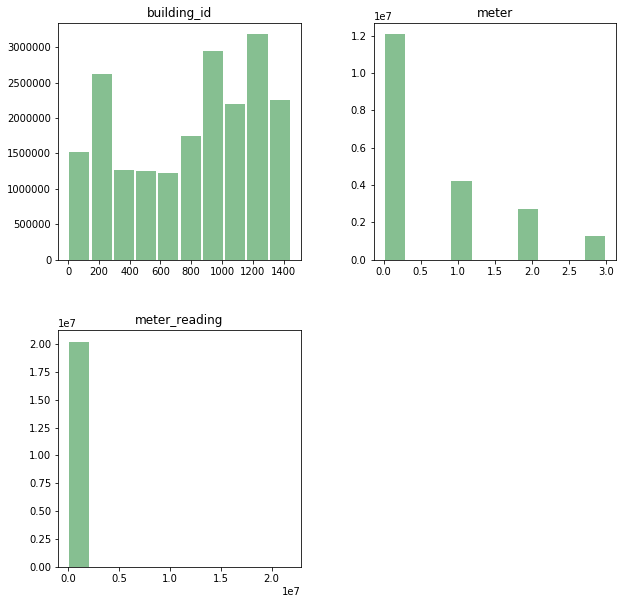

In [98]:
Train_DF.hist(bins=10, grid=False, figsize=(10,10), color='#86bf91', zorder=1, rwidth=0.9)

 ##  building_metadata.csv

In [99]:
BuildM_DF.shape


(1449, 6)

In [100]:
BuildM_DF.isnull().sum()
#We should drop the year_built and floor_count columns

site_id           0
building_id       0
primary_use       0
square_feet       0
year_built      774
floor_count    1094
dtype: int64

In [101]:
BuildM_DF.primary_use.value_counts()
#we should keep categories with value_count less than 100 in another new category

Education                        549
Office                           279
Entertainment/public assembly    184
Public services                  156
Lodging/residential              147
Other                             25
Healthcare                        23
Parking                           22
Warehouse/storage                 13
Manufacturing/industrial          12
Retail                            11
Services                          10
Technology/science                 6
Food sales and service             5
Utility                            4
Religious worship                  3
Name: primary_use, dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb18e055b70>,
      dtype=object)

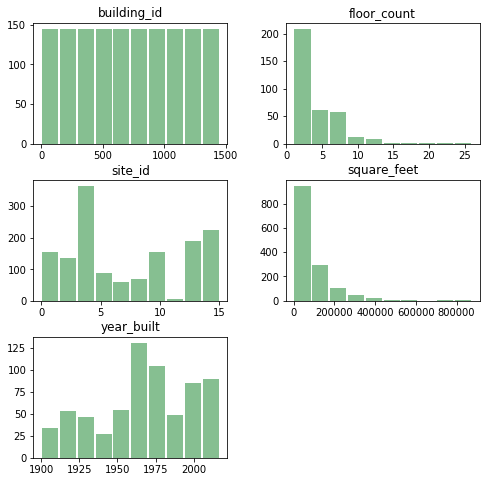

In [102]:
BuildM_DF.hist(bins=10, grid=False, figsize=(8,8), color='#86bf91', zorder=1, rwidth=0.9)

## weather_train.csv


In [103]:
Weather_train_DF.shape

(139773, 9)

In [104]:
Weather_train_DF.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,0,2016-01-01 01:00:00,24.4,NaN,21.1,-1.0,1020.2,70.0,1.5
2,0,2016-01-01 02:00:00,22.8,2.0,21.1,0.0,1020.2,0.0,0.0
3,0,2016-01-01 03:00:00,21.1,2.0,20.6,0.0,1020.1,0.0,0.0
4,0,2016-01-01 04:00:00,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6


In [105]:
Weather_train_DF.isnull().sum()
#Cloud_coverage and precip_depth_1_hr contains to much missing data (more than 30%), we should drop them.

site_id                   0
timestamp                 0
air_temperature          55
cloud_coverage        69173
dew_temperature         113
precip_depth_1_hr     50289
sea_level_pressure    10618
wind_direction         6268
wind_speed              304
dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb13f498c88>,
      dtype=object)

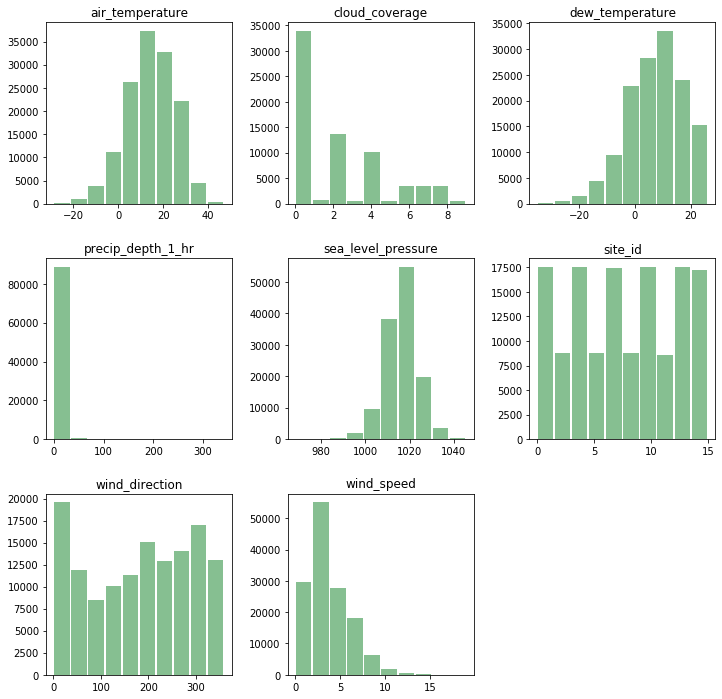

In [106]:
Weather_train_DF.hist(bins=10, grid=False, figsize=(12,12), color='#86bf91', zorder=1, rwidth=0.9)

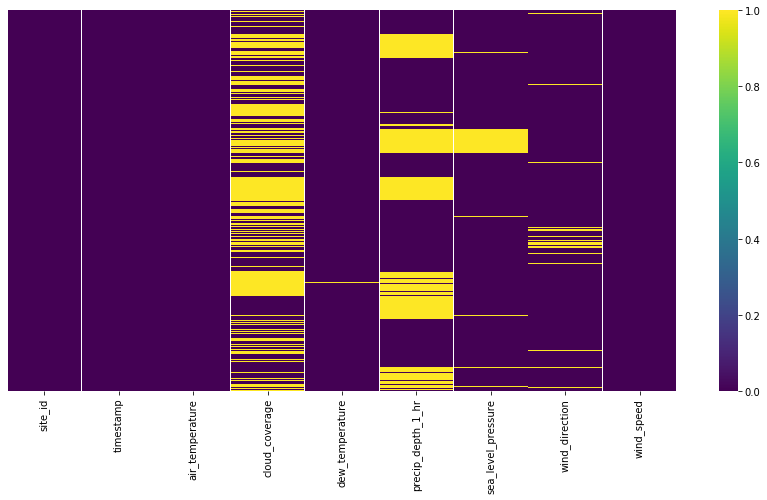

In [107]:
fig, ax = plt.subplots(figsize=(15,7))
sns.heatmap(Weather_train_DF.isnull(), yticklabels=False, cmap='viridis')

## Target Distribution

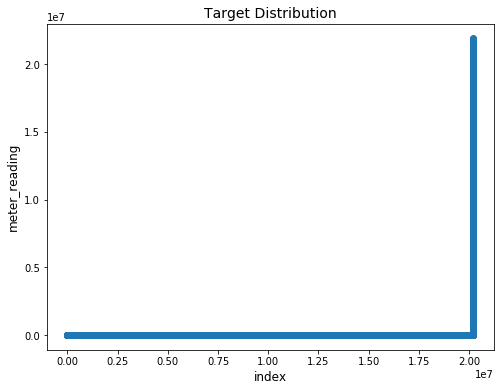

In [110]:
plt.figure(figsize=(8,6))
plt.scatter(range(Train_DF.shape[0]), np.sort(Train_DF['meter_reading'].values))
plt.xlabel('index', fontsize=12)
plt.ylabel('meter_reading', fontsize=12)
plt.title("Target Distribution", fontsize=14)
plt.show()

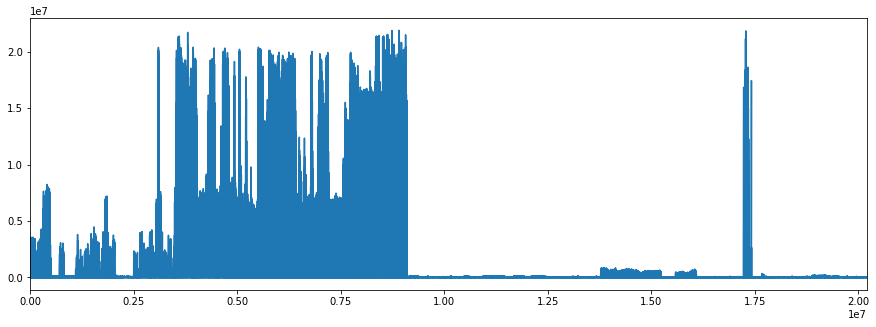

In [111]:
plt.figure(figsize = (15,5))
Train_DF['meter_reading'].plot()


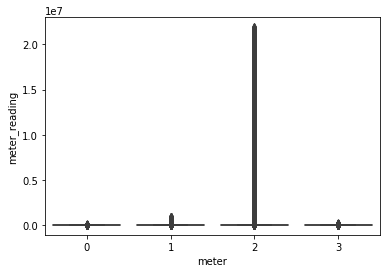

In [109]:
sns.boxplot(x = 'meter', y = 'meter_reading', data = Train_DF)

## Features visualisation

In [0]:
def plot_dist_col(column):
    '''plot dist curves for train and test weather data for the given column name'''
    fig, ax = plt.subplots(figsize=(10, 10))
    sns.distplot(Weather_train_DF[column].dropna(), color='green', ax=ax).set_title(column, fontsize=16)
    sns.distplot(Weather_Test_DF[column].dropna(), color='purple', ax=ax).set_title(column, fontsize=16)
    plt.xlabel(column, fontsize=15)
    plt.legend(['train', 'test'])
    plt.show()


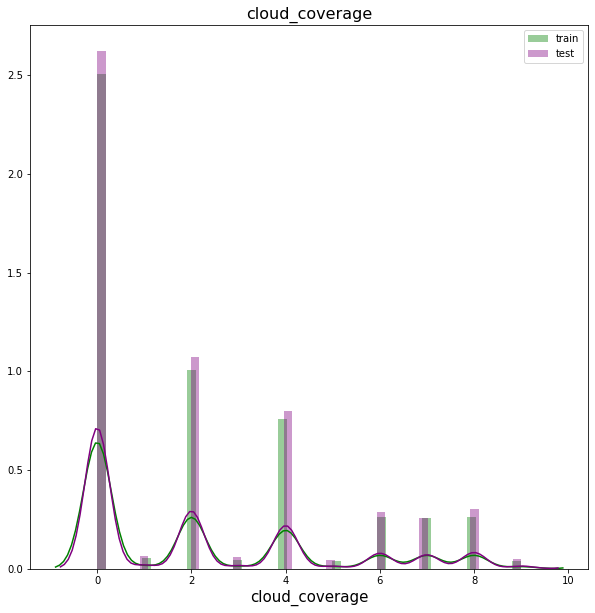

In [114]:
plot_dist_col('cloud_coverage')

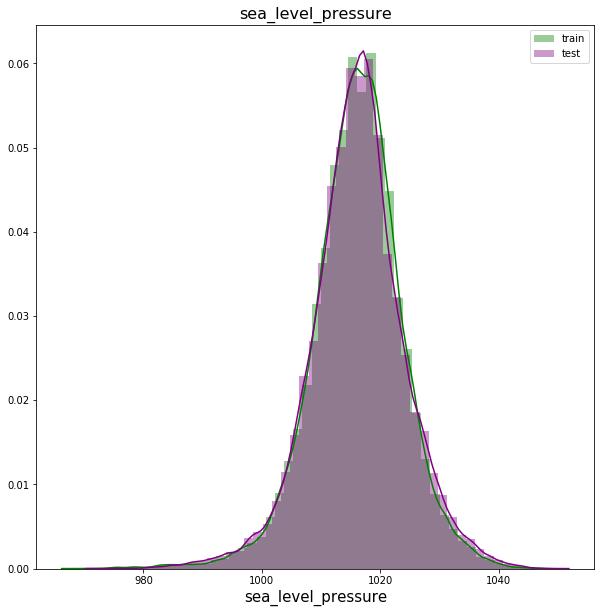

In [115]:
plot_dist_col('sea_level_pressure')

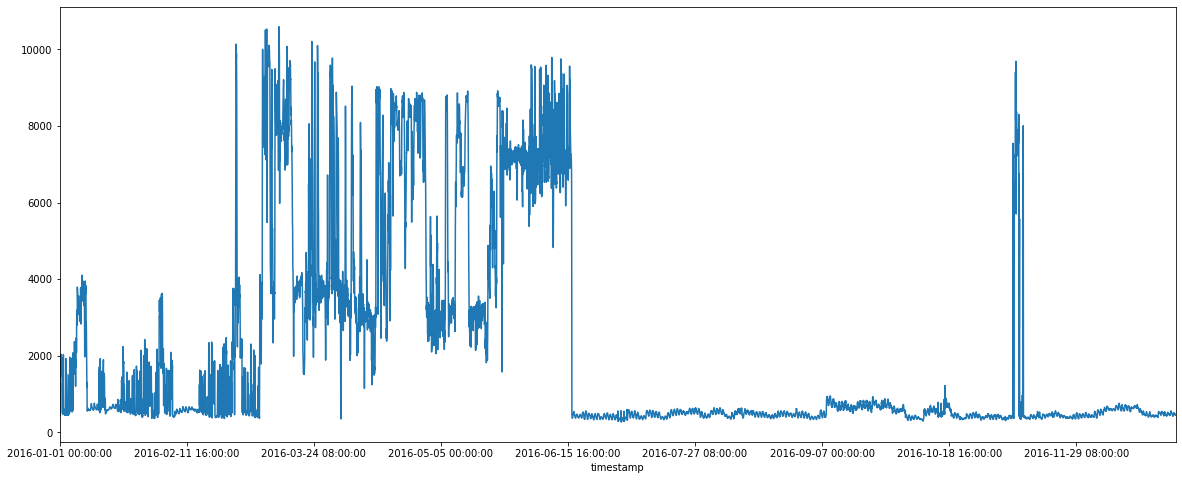

In [117]:
y_mean_time = Train_DF.groupby('timestamp').meter_reading.mean()
y_mean_time.plot(figsize=(20, 8))


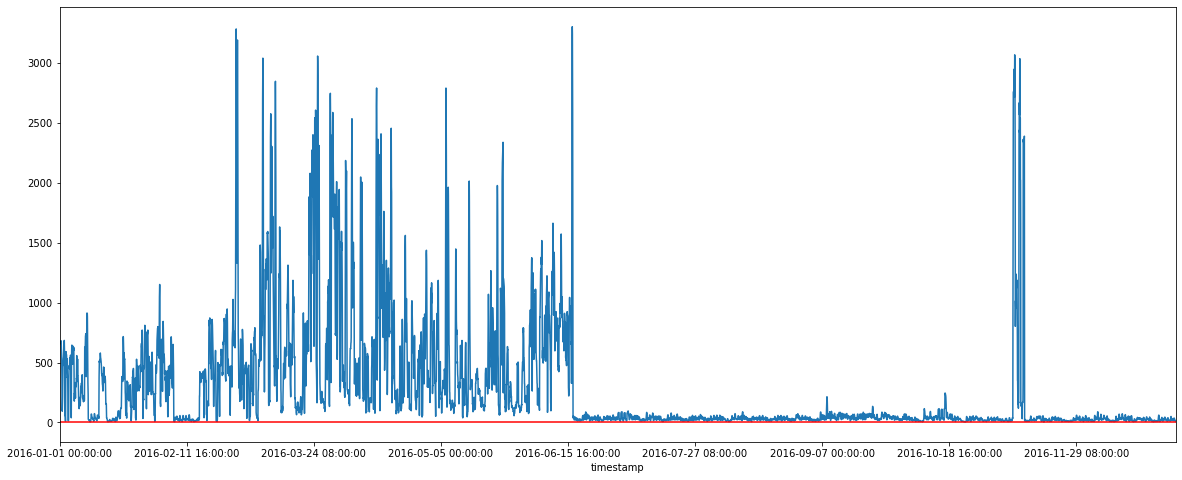

In [118]:
y_mean_time.rolling(window=10).std().plot(figsize=(20, 8))
ax = plt.axhline(y=0.009, color='red')


# Clean the Data and merge it

In [0]:
BuildM_DF = BuildM_DF.drop(columns=['year_built','floor_count'], axis=1)

In [0]:
categories=["Religious worship","Utility","Food sales and service","Technology/science","Services","Retail","Manufacturing/industrial","Warehouse/storage","Parking","Healthcare","Other"]
BuildM_DF.loc[BuildM_DF.primary_use.isin(categories),'primary_use'] = 'others'
BuildM_DF["primary_use"] = BuildM_DF["primary_use"].astype('category')
BuildM_DF["primary_use"] = BuildM_DF["primary_use"].cat.codes
BuildM_DF['primary_use'] = BuildM_DF.primary_use.astype("int64")

In [0]:
Weather_train_DF = Weather_train_DF.drop(columns=['precip_depth_1_hr','cloud_coverage','wind_direction','sea_level_pressure'], axis=1)

In [0]:
Weather_train_DF['air_temperature'].fillna(Weather_train_DF['air_temperature'].mean(), inplace=True)
Weather_train_DF['dew_temperature'].fillna(Weather_train_DF['dew_temperature'].mean(), inplace=True)
Weather_train_DF['wind_speed'].fillna(Weather_train_DF['wind_speed'].mean(), inplace=True)

In [11]:
Weather_train_DF.head()

,site_id,timestamp,air_temperature,dew_temperature,wind_speed
0,0,2016-01-01 00:00:00,25.0,20.0,0.0
1,0,2016-01-01 01:00:00,24.4,21.1,1.5
2,0,2016-01-01 02:00:00,22.8,21.1,0.0
3,0,2016-01-01 03:00:00,21.1,20.6,0.0
4,0,2016-01-01 04:00:00,20.0,20.0,2.6


In [12]:
Weather_train_DF.isnull().sum()


site_id            0
timestamp          0
air_temperature    0
dew_temperature    0
wind_speed         0
dtype: int64

In [0]:
Train_DF = Train_DF.merge(BuildM_DF, on='building_id', how='left')
Train_DF = Train_DF.merge(Weather_train_DF, on=['site_id', 'timestamp'], how='left')

In [14]:
Train_DF.shape

(20216100, 10)

In [0]:
    Train_DF["datetime"] = pd.to_datetime(Train_DF["timestamp"])
    Train_DF["day"] = Train_DF["datetime"].dt.day
    Train_DF["week"] = Train_DF["datetime"].dt.week
    Train_DF["month"] = Train_DF["datetime"].dt.month
    

In [0]:
Train_DF = Train_DF.drop(columns=[ 'timestamp','site_id','week'], axis=1)


In [0]:
Train_DF = Train_DF.drop(columns=['datetime'])

In [18]:
Train_DF.isnull().sum()

building_id            0
meter                  0
meter_reading          0
primary_use            0
square_feet            0
air_temperature    90495
dew_temperature    90495
wind_speed         90495
day                    0
month                  0
dtype: int64

In [0]:
Train_DF= Train_DF.dropna()

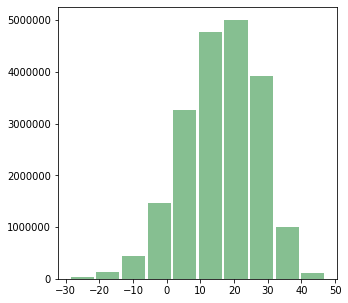

In [20]:
Train_DF.air_temperature.hist(bins=10, grid=False, figsize=(5,5), color='#86bf91', zorder=1, rwidth=0.9)

In [0]:
## Function to reduce the DF size
def reduce_memory_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [22]:
Train_DF.isnull().sum()

building_id        0
meter              0
meter_reading      0
primary_use        0
square_feet        0
air_temperature    0
dew_temperature    0
wind_speed         0
day                0
month              0
dtype: int64

In [23]:
reduce_memory_usage(Train_DF)

Mem. usage decreased to 537.41 Mb (68.2% reduction)


,building_id,meter,meter_reading,primary_use,square_feet,air_temperature,dew_temperature,wind_speed,day,month
0,0,0,0.000000,0,7432,25.000000,20.000000,0.000000,1,1
1,1,0,0.000000,0,2720,25.000000,20.000000,0.000000,1,1
2,2,0,0.000000,0,5376,25.000000,20.000000,0.000000,1,1
3,3,0,0.000000,0,23685,25.000000,20.000000,0.000000,1,1
4,4,0,0.000000,0,116607,25.000000,20.000000,0.000000,1,1
...,...,...,...,...,...,...,...,...,...,...
20216095,1444,0,8.750000,1,19619,1.700195,-5.601562,8.796875,31,12
20216096,1445,0,4.825000,0,4298,1.700195,-5.601562,8.796875,31,12
20216097,1446,0,0.000000,1,11265,1.700195,-5.601562,8.796875,31,12
20216098,1447,0,159.574997,2,29775,1.700195,-5.601562,8.796875,31,12


# Split Train_Test

In [24]:
from sklearn.model_selection import train_test_split
train_df,test_df = train_test_split(Train_DF, test_size=0.2, random_state=45)
train_df.head()

,building_id,meter,meter_reading,primary_use,square_feet,air_temperature,dew_temperature,wind_speed,day,month
9659130,179,1,222.757004,5,24867,35.593750,10.601562,4.101562,26,6
194120,890,0,436.000000,0,202937,3.300781,-1.099609,2.599609,4,1
10908162,1311,0,48.945801,2,66794,26.703125,21.703125,3.099609,18,7
15059245,1119,2,0.000000,3,119509,18.296875,10.601562,4.601562,1,10
1097070,224,0,544.150024,0,272278,20.000000,2.199219,1.500000,20,1


In [25]:
print (train_df.isnull().sum())


building_id        0
meter              0
meter_reading      0
primary_use        0
square_feet        0
air_temperature    0
dew_temperature    0
wind_speed         0
day                0
month              0
dtype: int64


In [0]:
y_test = test_df['meter_reading']
x_test = test_df[['meter','building_id', 'primary_use', 'month', 'day','air_temperature','dew_temperature', 'wind_speed','square_feet']]

y_train = train_df['meter_reading']
x_train = train_df[['meter','building_id', 'primary_use', 'month', 'day','air_temperature','dew_temperature', 'wind_speed','square_feet']]

In [0]:
# store the clean data in a pickle file to be used later in the modeling phase

import pickle
with open('train_test.pickle', 'wb') as f:
    pickle.dump([x_train, y_train, x_test,y_test], f)


# Run and evaluate Model

In [29]:
x_train.shape,y_train.shape, x_test.shape,y_test.shape


((16100484, 9), (16100484,), (4025121, 9), (4025121,))

In [30]:
from sklearn import preprocessing
from keras import backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, LSTM, GRU, Dropout, BatchNormalization
from keras.models import Sequential
from keras.optimizers import RMSprop,Adam
from keras import regularizers


Using TensorFlow backend.


In [0]:
es = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5, verbose=True, mode='auto')

In [0]:
def root_mean_squared_error(y_true, y_pred):
  return K.sqrt(K.mean(K.square(y_pred - y_true)))
  
metrics=root_mean_squared_error


In [34]:
x_train.isnull().sum()

meter              0
building_id        0
primary_use        0
month              0
day                0
air_temperature    0
dew_temperature    0
wind_speed         0
square_feet        0
dtype: int64

In [0]:
def make_model(input_dim=9,metrics=root_mean_squared_error,loss='mse', optimizer="rmsprop",drop_rate=0.2):

  model = Sequential()
  model.add(LSTM(128,return_sequences=True, input_shape=(None,input_dim)))
  model.add(Dropout(drop_rate))
  model.add(BatchNormalization())
  model.add(LSTM(128,return_sequences=False))
  model.add(BatchNormalization())
  model.add(Dropout(drop_rate))
  model.add(Dense(1))
  model.compile(optimizer=optimizer, loss=loss, metrics=[metrics])
  
  return model

In [0]:
def run_model(model,x_train,y_train,epochs=50,batch_size=500,verbose=1,validation_data=(x_test,y_test),callbacks =None):
  x_train = x_train.values[:]
  x_train= x_train.reshape((x_train.shape[0],1,x_train.shape[-1]))
  y_train = np.log1p(y_train)
  if validation_data != None:
    x_test = validation_data[0].values[:]
    x_test = x_test.reshape((x_test.shape[0],1,x_test.shape[-1]))
    y_test = np.log1p(validation_data[-1])
      
  return model.fit(x_train,y_train,epochs=epochs,batch_size=batch_size,verbose=verbose,validation_data=(x_test,y_test),callbacks=callbacks)

In [37]:
model3 = make_model(input_dim=9,drop_rate=0.2)





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



In [38]:
model3.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, None, 128)         70656     
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 128)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 128)         512       
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)               512       
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

In [39]:
history2 = run_model(model3,x_train,y_train,epochs=5,batch_size=500,verbose=1,validation_data=(x_test,y_test), callbacks =[es]) 

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 16100484 samples, validate on 4025121 samples
Epoch 1/5





16100484/16100484 [==============================] - 748s 46us/step - loss: 4.6163 - root_mean_squared_error: 2.1452 - val_loss: 4.5666 - val_root_mean_squared_error: 2.1359
Epoch 2/5
16100484/16100484 [==============================] - 743s 46us/step - loss: 4.5717 - root_mean_squared_error: 2.1371 - val_loss: 4.5674 - val_root_mean_squared_error: 2.1361
Epoch 3/5
16100484/16100484 [==============================] - 718s 45us/step - loss: 4.5674 - root_mean_squared_error: 2.1361 - val_loss: 4.5749 - val_root_mean_squared_error: 2.1378
Epoch 4/5
16100484/16100484 [==============================] - 747s 46us/step - loss: 4.5656 - root_mean_squared_error: 2.1357 - val_loss: 4.5686 - val_root_mean_squared_error: 2.1364
Epoch 5/5
16100484/16100484 [==============================] - 731s 45us/step - loss: 4.5650 - root_mean_sq

In [40]:
loss = history2.history
loss.keys()

dict_keys(['val_loss', 'val_root_mean_squared_error', 'loss', 'root_mean_squared_error'])

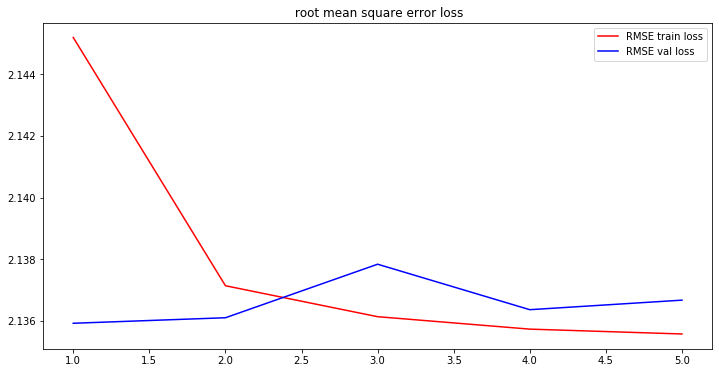

In [41]:
#rmse loss
rmse_loss_train = loss['root_mean_squared_error']
rmse_loss_val = loss['val_root_mean_squared_error']
epochs_stops = es.stopped_epoch +1 # epochs number from early stopping
epochs = range(1,6)  #len(loss_train)
plt.figure(figsize=(12,6))
plt.plot(epochs,rmse_loss_train,'r', label='RMSE train loss')
plt.plot(epochs,rmse_loss_val,'b',label='RMSE val loss')
plt.title(' root mean square error loss')
plt.legend()
plt.show()

# Data Test Cleaning

In [0]:
BuildM_DF_T=pd.read_csv("building_metadata.csv")
Weather_train_DF_T = pd.read_csv("weather_train.csv")
Weather_Test_DF_T = pd.read_csv("weather_test.csv")
Test_DF_T = pd.read_csv("test.csv")


In [0]:
Test_DF_T = pd.read_csv("test.csv")


In [0]:
BuildM_DF_T = BuildM_DF_T.drop(columns=['year_built','floor_count'], axis=1)

In [0]:
categories=["Religious worship","Utility","Food sales and service","Technology/science","Services","Retail","Manufacturing/industrial","Warehouse/storage","Parking","Healthcare","Other"]
BuildM_DF_T.loc[BuildM_DF_T.primary_use.isin(categories),'primary_use'] = 'others'
BuildM_DF_T["primary_use"] = BuildM_DF_T["primary_use"].astype('category')
BuildM_DF_T["primary_use"] = BuildM_DF_T["primary_use"].cat.codes
BuildM_DF_T['primary_use'] = BuildM_DF_T.primary_use.astype("int64")

In [0]:
Weather_Test_DF_T = Weather_Test_DF_T.drop(columns=['precip_depth_1_hr','cloud_coverage','wind_direction','sea_level_pressure'], axis=1)

In [47]:
Weather_Test_DF_T.isnull().sum()

site_id              0
timestamp            0
air_temperature    104
dew_temperature    327
wind_speed         460
dtype: int64

In [0]:
Weather_Test_DF_T['air_temperature'].fillna(Weather_Test_DF_T['air_temperature'].mean(), inplace=True)
Weather_Test_DF_T['dew_temperature'].fillna(Weather_Test_DF_T['dew_temperature'].mean(), inplace=True)
Weather_Test_DF_T['wind_speed'].fillna(Weather_Test_DF_T['wind_speed'].mean(), inplace=True)

In [49]:
Weather_Test_DF_T.head()

,site_id,timestamp,air_temperature,dew_temperature,wind_speed
0,0,2017-01-01 00:00:00,17.8,11.7,3.6
1,0,2017-01-01 01:00:00,17.8,12.8,3.1
2,0,2017-01-01 02:00:00,16.1,12.8,3.1
3,0,2017-01-01 03:00:00,17.2,13.3,3.1
4,0,2017-01-01 04:00:00,16.7,13.3,2.6


In [0]:
Test_DF_T = Test_DF_T.merge(BuildM_DF_T, on='building_id', how='left')

In [0]:
Test_DF_T = Test_DF_T.merge(Weather_Test_DF_T,left_on=['site_id','timestamp'],right_on=['site_id','timestamp'],how='left')


In [0]:
    Test_DF_T["datetime"] = pd.to_datetime(Test_DF_T["timestamp"])
    Test_DF_T["day"] = Test_DF_T["datetime"].dt.day
    Test_DF_T["week"] = Test_DF_T["datetime"].dt.week
    Test_DF_T["month"] = Test_DF_T["datetime"].dt.month
    

In [0]:
Test_DF_T = Test_DF_T.drop(columns=['datetime','row_id'])

In [58]:
Test_DF_T.isnull().sum()

building_id        0
meter              0
timestamp          0
site_id            0
primary_use        0
square_feet        0
air_temperature    0
dew_temperature    0
wind_speed         0
day                0
week               0
month              0
dtype: int64

In [0]:
Test_DF_T['air_temperature'].fillna(Test_DF_T['air_temperature'].mean(), inplace=True)
Test_DF_T['dew_temperature'].fillna(Test_DF_T['dew_temperature'].mean(), inplace=True)
Test_DF_T['wind_speed'].fillna(Test_DF_T['wind_speed'].mean(), inplace=True)

In [56]:
Test_DF_T

,building_id,meter,timestamp,site_id,primary_use,square_feet,air_temperature,dew_temperature,wind_speed,day,week,month
0,0,0,2017-01-01 00:00:00,0,0,7432,17.8,11.7,3.6,1,52,1
1,1,0,2017-01-01 00:00:00,0,0,2720,17.8,11.7,3.6,1,52,1
2,2,0,2017-01-01 00:00:00,0,0,5376,17.8,11.7,3.6,1,52,1
3,3,0,2017-01-01 00:00:00,0,0,23685,17.8,11.7,3.6,1,52,1
4,4,0,2017-01-01 00:00:00,0,0,116607,17.8,11.7,3.6,1,52,1
...,...,...,...,...,...,...,...,...,...,...,...,...
41697595,1444,0,2018-05-09 07:00:00,15,1,19619,NaN,NaN,NaN,9,19,5
41697596,1445,0,2018-05-09 07:00:00,15,0,4298,NaN,NaN,NaN,9,19,5
41697597,1446,0,2018-05-09 07:00:00,15,1,11265,NaN,NaN,NaN,9,19,5
41697598,1447,0,2018-05-09 07:00:00,15,2,29775,NaN,NaN,NaN,9,19,5


In [0]:
Test_DF_T = Test_DF_T.drop(columns=['week'])

In [80]:
x_train

,meter,building_id,primary_use,month,day,air_temperature,dew_temperature,wind_speed,square_feet
9659130,1,179,5,6,26,35.593750,10.601562,4.101562,24867
194120,0,890,0,1,4,3.300781,-1.099609,2.599609,202937
10908162,0,1311,2,7,18,26.703125,21.703125,3.099609,66794
15059245,2,1119,3,10,1,18.296875,10.601562,4.601562,119509
1097070,0,224,0,1,20,20.000000,2.199219,1.500000,272278
...,...,...,...,...,...,...,...,...,...
2508447,1,1185,3,2,16,-0.600098,-3.900391,4.101562,129532
17812702,0,1249,3,11,19,11.703125,2.199219,1.500000,159384
867999,0,750,0,1,16,12.796875,0.000000,4.101562,35990
11528968,0,549,4,7,30,28.906250,22.203125,3.099609,12754


In [0]:
x_test_F = Test_DF_T[['meter', 'building_id', 'primary_use', 'month', 'day','air_temperature', 'dew_temperature', 'wind_speed','square_feet']]

In [0]:
reduce_memory_usage(x_test_F)

In [0]:
x_test_F = x_test_F.values[:]

In [63]:
x_test_F.shape

(41697600, 9)

In [0]:
x_test_F = x_test_F.reshape((x_test_F.shape[0],1,x_test_F.shape[-1]))

# Submit

In [66]:
predicted =model3.predict(x_test_F, batch_size=1024, verbose=1)


41697600/41697600 [==============================] - 402s 10us/step


In [0]:
predicted = np.expm1(predicted)


In [68]:
len(predicted)

41697600

In [0]:
submit = pd.read_csv('sample_submission.csv')

In [0]:
submit['meter_reading'] = predicted


In [0]:
submit.to_csv('submission.csv', index=False,float_format='%.4f')

In [73]:
submit.head()


,row_id,meter_reading
0,0,59.484806
1,1,59.484806
2,2,59.484806
3,3,59.484806
4,4,59.484806


In [75]:
!kaggle competitions submit ashrae-energy-prediction -f submission.csv -m 'Final submission'


100% 665M/665M [00:26<00:00, 26.4MB/s]
Successfully submitted to ASHRAE - Great Energy Predictor III